In [1]:
from google.colab import drive
drive.mount('/content/drive')

!rm -rf sample_data/

Mounted at /content/drive


In [ ]:
!cp /content//MyDrive/Beat_Data.zip /content/beedataready.zip

cp: cannot stat '/content/drive/MyDrive/Beat_Data.zip': No such file or directory


In [2]:
!unzip /content/Beat_Data.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/out/train/Bombus_affinis/NRYKARFK3RX0Q0W0L0W0S0G0DQX0ARZQFQZQJR7QBR7QAR7QORKQYRXQFRHQYQG0YQ80DQRQNRZQURM0CQM0JQFKFQLQ.png  
  inflating: content/out/train/Bombus_affinis/Bombus_affinis_GBIF_iNat_3327687068_2.jpg.png  
  inflating: content/out/train/Bombus_affinis/Bombus_affinis_GBIF_iNat_3333253088_2.jpg.png  
  inflating: content/out/train/Bombus_affinis/BBB_Bombus_affinis_1906-1_1.png  
  inflating: content/out/train/Bombus_affinis/Bombus_affinis_14906017_5_1.png  
  inflating: content/out/train/Bombus_affinis/Bombus_affinis_GBIF_iNat_3385029953_4.jpg.png  
  inflating: content/out/train/Bombus_affinis/BBB_Bombus_affinis_3377-3_1.png  
  inflating: content/out/train/Bombus_affinis/Bombus_affinis_56090624_2_1.png  
  inflating: content/out/train/Bombus_affinis/Bombus_affinis_55829511_3_1.png  
  inflating: content/out/train/Bombus_affinis/Bombus_affinis_GBIF_iNat_3343716771_2.jpg.png  
  inflating: content/out/tra

In [3]:
!pip install 'h5py==2.10.0' --force-reinstall
!pip install ISR

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 5.0 MB/s 
     |████████████████████████████████| 15.7 MB 44.9 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86.3 MB 48 kB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
     |████████████████████████████████| 3.8 MB 34.5 MB/s 
     |████████████████████████████████| 449 kB 59.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=31c8c3e9078ded9d5184308adb2277c63d6423ff9608fcc16502f3e2d1a734ab
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uni

In [4]:
#from ISR.models import RRDN
from ISR.models import RRDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19

In [5]:
lr_train_patch_size = 40
layers_to_extract = [5, 9]
scale = 2
hr_train_patch_size = lr_train_patch_size * scale
#  4  3 64 64 10 2
#  5 16 48 52 10 2
#  8  4 64 64 10 2
# 15 15 64 64 10 2
rrdn  = RRDN(arch_params={'C':2, 'D':2, 'G':64, 'G0':64, 'T': 10, 'x':scale}, patch_size=lr_train_patch_size)
f_ext = Cut_VGG19(patch_size=hr_train_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_train_patch_size, kernel_size=3)

80142336/80134624 [==============================] - 3s 0us/step


AttributeError: ignored

In [ ]:

!ls /content/content/out/val_LR | wc -l

ls: cannot access '/content/content/out/val_LR': No such file or directory
0


In [6]:
from ISR.train import Trainer
loss_weights = {
  'generator': 0.0,
  'feature_extractor': 0.0833,
  'discriminator': 0.01
}
losses = {
  'generator': 'mae',
  'feature_extractor': 'mse',
  'discriminator': 'binary_crossentropy'
} 

log_dirs = {'logs': './logs', 'weights': './weights'}

learning_rate = {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}

flatness = {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}

trainer = Trainer(
    generator=rrdn,
    discriminator=discr,
    feature_extractor=f_ext,
    lr_train_dir='/content/content/out/train_LR/',
    hr_train_dir='/content/content/out/train/Bombus_affinis/',
    lr_valid_dir='/content/content/out/val_LR/',
    hr_valid_dir='/content/content/out/val/Bombus_affinis/',
    loss_weights=loss_weights,
    learning_rate=learning_rate,
    flatness=flatness,
    dataname='div2k',
    log_dirs=log_dirs,
    weights_generator=None,
    weights_discriminator=None,
    n_validation=40,
)

In [ ]:
trainer.train(
    epochs=32,
    steps_per_epoch=20,
    batch_size=4,
    monitored_metrics={'val_generator_PSNR_Y': 'max'}
    #monitored_metrics={'val_generator_loss' : 'min'}
)


Training details:
  training_parameters: 
    lr_train_dir: /content/content/out/train_LR/
    hr_train_dir: /content/content/out/train/Bombus_affinis/
    lr_valid_dir: /content/content/out/val_LR/
    hr_valid_dir: /content/content/out/val/Bombus_affinis/
    loss_weights: {'generator': 0.0, 'feature_extractor': 0.0833, 'discriminator': 0.01}
    log_dirs: {'logs': './logs', 'weights': './weights'}
    fallback_save_every_n_epochs: 2
    dataname: div2k
    n_validation: 40
    flatness: {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}
    learning_rate: {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}
    adam_optimizer: {'beta1': 0.9, 'beta2': 0.999, 'epsilon': None}
    losses: {'generator': 'mae', 'discriminator': 'binary_crossentropy', 'feature_extractor': 'mse'}
    metrics: {'generator': <function PSNR_Y at 0x7f8e0e05b320>}
    lr_patch_size: 40
    steps_per_epoch: 20
    batch_size: 4
    starting_epoch: 0
  generator: 
    name: rrd

Epoch 0/32
Current learning rate: 0.00039999998989515007
100%|██████████| 20/20 [04:28<00:00, 13.40s/it]
Epoch 0 took      268.1s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.5658041540533304, 'val_generator_loss': 0.31840163, 'val_discriminator_loss': 0.045535482, 'val_feature_extractor_loss': 2.6192365, 'val_feature_extractor_1_loss': 10.954565, 'val_generator_PSNR_Y': 10.247976, 'train_d_real_loss': 0.014499402, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.013179254, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.61053944, 'train_generator_loss': 0.37908894, 'train_discriminator_loss': 0.071512945, 'train_feature_extractor_loss': 2.5436234, 'train_feature_extractor_1_loss': 12.098017, 'train_generator_PSNR_Y': 8.5168495}
val_generator_PSNR_Y improved from       -inf to   10.24798
Saving weights
Epoch 1/32
Current learning rate: 0.00039999998989515007
100%|██████████| 20/20 [04:27<00:00, 13.35s/it]
Epoch 1 took      267.1s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.3680942479521036, 'val_generator_loss': 0.18243921, 'val_discriminator_loss': 1.3139086, 'val_feature_extractor_loss': 1.5858624, 'val_feature_extractor_1_loss': 6.936471, 'val_generator_PSNR_Y': 15.249044, 'train_d_real_loss': 0.5776491, 'train_d_real_accuracy': 0.76875, 'train_d_fake_loss': 0.31424922, 'train_d_fake_accuracy': 0.99, 'train_loss': 0.2526549, 'train_generator_loss': 0.14913647, 'train_discriminator_loss': 0.4279722, 'train_feature_extractor_loss': 1.0982305, 'train_feature_extractor_1_loss': 4.8651595, 'train_generator_PSNR_Y': 16.350359}
val_generator_PSNR_Y improved from   10.24798 to   15.24904
Saving weights
Epoch 2/32
Current learning rate: 0.00039999998989515007
100%|██████████| 20/20 [04:33<00:00, 13.68s/it]
Epoch 2 took      273.5s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.28454665634781123, 'val_generator_loss': 0.18160501, 'val_discriminator_loss': 1.7594202, 'val_feature_extractor_loss': 1.2551405, 'val_feature_extractor_1_loss': 5.154281, 'val_generator_PSNR_Y': 15.3464, 'train_d_real_loss': 0.598954, 'train_d_real_accuracy': 0.68375, 'train_d_fake_loss': 0.31515166, 'train_d_fake_accuracy': 0.86875, 'train_loss': 0.24083671, 'train_generator_loss': 0.1914153, 'train_discriminator_loss': 1.5766107, 'train_feature_extractor_loss': 0.92242706, 'train_feature_extractor_1_loss': 4.4814286, 'train_generator_PSNR_Y': 13.511755}
val_generator_PSNR_Y improved from   15.24904 to   15.34640
Saving weights
Epoch 3/32
Current learning rate: 0.00039999998989515007
100%|██████████| 20/20 [04:28<00:00, 13.40s/it]
Epoch 3 took      268.0s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.17758967261761427, 'val_generator_loss': 0.1376849, 'val_discriminator_loss': 0.572068, 'val_feature_extractor_loss': 0.807999, 'val_feature_extractor_1_loss': 3.318507, 'val_generator_PSNR_Y': 17.662575, 'train_d_real_loss': 0.9364471, 'train_d_real_accuracy': 0.526875, 'train_d_fake_loss': 3.0847156, 'train_d_fake_accuracy': 0.006875, 'train_loss': 0.35973692, 'train_generator_loss': 0.14108083, 'train_discriminator_loss': 0.4422239, 'train_feature_extractor_loss': 1.6154847, 'train_feature_extractor_1_loss': 6.9154797, 'train_generator_PSNR_Y': 19.09452}
val_generator_PSNR_Y improved from   15.34640 to   17.66257
Saving weights
Epoch 4/32
Current learning rate: 0.00039999998989515007
100%|██████████| 20/20 [04:25<00:00, 13.29s/it]
Epoch 4 took      265.9s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.16344505324959754, 'val_generator_loss': 0.15048788, 'val_discriminator_loss': 0.06879939, 'val_feature_extractor_loss': 0.79734796, 'val_feature_extractor_1_loss': 3.1103842, 'val_generator_PSNR_Y': 17.625431, 'train_d_real_loss': 0.015255179, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.02928492, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.21837777, 'train_generator_loss': 0.19237593, 'train_discriminator_loss': 0.04120912, 'train_feature_extractor_loss': 0.9398127, 'train_feature_extractor_1_loss': 4.2934566, 'train_generator_PSNR_Y': 15.094985}
val_generator_PSNR_Y did not improve.
Epoch 5/32
Current learning rate: 0.00039999998989515007
Current flatness treshold: 0.01
100%|██████████| 20/20 [04:27<00:00, 13.39s/it]
Epoch 5 took      267.8s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.11685148258693516, 'val_generator_loss': 0.1220183, 'val_discriminator_loss': 0.39986822, 'val_feature_extractor_loss': 0.60797566, 'val_feature_extractor_1_loss': 2.1015754, 'val_generator_PSNR_Y': 19.876986, 'train_d_real_loss': 0.059946384, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.014160411, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.08330104, 'train_generator_loss': 0.14287555, 'train_discriminator_loss': 0.42422485, 'train_feature_extractor_loss': 0.3527419, 'train_feature_extractor_1_loss': 1.5454282, 'train_generator_PSNR_Y': 18.512362}
val_generator_PSNR_Y improved from   17.66257 to   19.87699
Saving weights
Epoch 6/32
Current learning rate: 0.00039999998989515007
Current flatness treshold: 0.01
100%|██████████| 20/20 [04:26<00:00, 13.33s/it]
Epoch 6 took      266.6s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.12522300723940133, 'val_generator_loss': 0.13174316, 'val_discriminator_loss': 0.12394657, 'val_feature_extractor_loss': 0.64982736, 'val_feature_extractor_1_loss': 2.3269684, 'val_generator_PSNR_Y': 18.379988, 'train_d_real_loss': 0.013418248, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.011530349, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.13885418, 'train_generator_loss': 0.18539543, 'train_discriminator_loss': 0.05461822, 'train_feature_extractor_loss': 0.67041636, 'train_feature_extractor_1_loss': 2.6503036, 'train_generator_PSNR_Y': 15.434488}
val_generator_PSNR_Y did not improve.
Epoch 7/32
Current learning rate: 0.00039999998989515007
Current flatness treshold: 0.01
100%|██████████| 20/20 [04:28<00:00, 13.44s/it]
Epoch 7 took      268.9s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.07575850230641663, 'val_generator_loss': 0.10638894, 'val_discriminator_loss': 0.09403072, 'val_feature_extractor_loss': 0.45710412, 'val_feature_extractor_1_loss': 1.3392508, 'val_generator_PSNR_Y': 21.638712, 'train_d_real_loss': 0.008254729, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.007750609, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.02275258, 'train_generator_loss': 0.06230283, 'train_discriminator_loss': 0.23314144, 'train_feature_extractor_loss': 0.1072208, 'train_feature_extractor_1_loss': 0.38308325, 'train_generator_PSNR_Y': 25.508024}
val_generator_PSNR_Y improved from   19.87699 to   21.63871
Saving weights
Epoch 8/32
Current learning rate: 0.00039999998989515007
Current flatness treshold: 0.01
 45%|████▌     | 9/20 [02:01<02:29, 13.57s/it]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


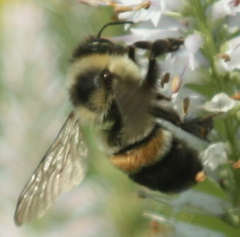

In [1]:
!pip install 'h5py==2.10.0' --force-reinstall
!pip install ISR

#!wget https://www.freeiconspng.com/uploads/download-bee-latest-version-2018-24.png
#!mkdir -p data/input/test_images
#!mv *.png data/input/test_images

import numpy as np
from PIL import Image

img = Image.open('/content/drive/MyDrive/Bombus_affinis_32985954_2_1.png')
img




In [ ]:
img = Image.open('/content/drive/MyDrive/Bombus_affinis_32985954_2_1.png')
img

In [2]:

from ISR.models import RDN, RRDN

# model = RDN(weights='noise-cancel')
#model = RRDN(weights='gans')
# model = RDN(weights='psnr-small')
# model = RDN(weights='psnr-large')




In [6]:
rdn = RDN(arch_params={'C': 4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':2})
rdn.model.load_weights("/content/weights/rdn-C4-D3-G64-G064-T10-x2/2022-08-07_0545/rdn-C4-D3-G64-G064-T10-x2_best-val_generator_PSNR_Y_epoch008.hdf5")

In [ ]:
rdn = RRDN(arch_params={'C': 4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':2})
rdn.model.load_weights("/content/rrdn-C5-D16-G48-G052-T10-x2_best-val_generator_PSNR_Y_epoch009.hdf5")

OSError: ignored

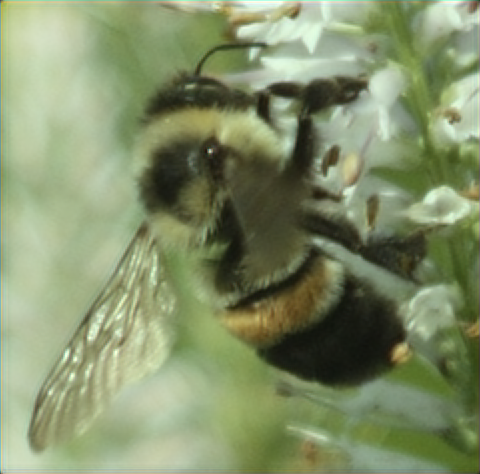

In [8]:
img.resize(size=(img.size[0]*4, img.size[1]*4), resample=Image.BICUBIC)


sr_img = rdn.predict(np.array(img))
#sr_img = model.predict(np.array(img))
Image.fromarray(sr_img)

#img.save('/content/compressed.jpeg','JPEG', dpi=[300, 300], quality=50)
#compressed_img = Image.open('/content/compressed.jpeg')

#compressed_img


#compressed_img.resize(size=(compressed_img.size[0]*2, compressed_img.size[1]*2), resample=Image.BICUBIC)


#model = RDN(weights='noise-cancel')
#sr_img = model.predict(np.array(compressed_img))
#Image.fromarray(sr_img)





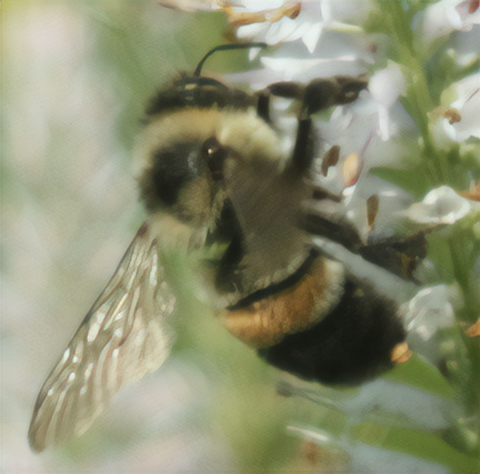

In [ ]:
img.save('/content/compressed.jpeg','JPEG', dpi=[300, 300], quality=100)
compressed_img = Image.open('/content/compressed.jpeg')

#compressed_img


compressed_img.resize(size=(compressed_img.size[0]*2, compressed_img.size[1]*2), resample=Image.BICUBIC)


model = RDN(weights='noise-cancel')
sr_img = model.predict(np.array(compressed_img))
Image.fromarray(sr_img)


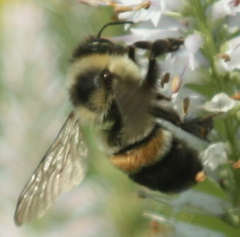

In [ ]:
Image.fromarray(sr_img)

orgin = Image.open("/content/drive/MyDrive/Bombus_affinis_32985954_2_1.png")
orgin

66076672/66071288 [==============================] - 4s 0us/step


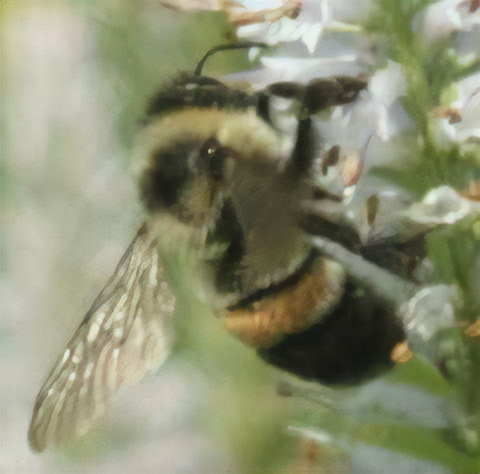

In [ ]:
img.resize(size=(img.size[0]*4, img.size[1]*4), resample=Image.BICUBIC)


sr_img = rdn.predict(np.array(img))
#sr_img = model.predict(np.array(img))
Image.fromarray(sr_img)

img.save('/content/compressed.jpeg','JPEG', dpi=[300, 300], quality=50)
compressed_img = Image.open('/content/compressed.jpeg')

compressed_img


compressed_img.resize(size=(compressed_img.size[0]*2, compressed_img.size[1]*2), resample=Image.BICUBIC)


model = RDN(weights='noise-cancel')
sr_img = model.predict(np.array(compressed_img))
Image.fromarray(sr_img)



